In [14]:
from github import Github
import pandas as pd
import time
import os
import requests
import datetime
from IPython.display import clear_output
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
color_6 = '#fb5607'
color_5 = '#ef476f'
color_2 = '#ffd166'
color_3 = '#06d6a0'
color_4 = '#118ab2'
color_1 = '#073b4c'
color_palette = [color_1, color_2, color_3, color_4, color_5, color_6]

import seaborn as sns
sns.set(font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

In [2]:
def create_folder_if_not_exist(folder_path):
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)
    return(folder_path)
        
def save_image_png(fig, folder_path, plot_name):
    folder_path = create_folder_if_not_exist(folder_path)
    file_name = plot_name + ".png"
    file_path = os.path.join(folder_path, file_name)
    fig.savefig(file_path, bbox_inches='tight')
    
current_folder = os.getcwd()

# Rise of Biomedical Research Software

## GitHub repositories

In [3]:
GITHUB_ACCESS_TOKEN = os.getenv('GITHUB_ACCESS_TOKEN')
g = Github(GITHUB_ACCESS_TOKEN)
print('Success: GitHub Access Token loaded')

Success: GitHub Access Token loaded


In [9]:
#get number of repositories on GitHub with "biomedical" included in the name, readme, or description created in a given month of a year
#since the GitHub API has a result rate limit of 1000, we search month by month assuming no single month has more than 1000 results
#we then combined monthly results to get year-wise number of repositories created with keyword biomedical
#results are saved in a dataframe and csv file for further analysis
#this code block can be skipped since the csv file with results is included with the code
def search_github_repo_created_month(keywords, created_month):
    created_month_query  = ' created:' + created_month
    query = keywords + ' in:name'+ ' in:readme' + ' in:description' + created_month_query
    result = g.search_repositories(query)
    return result

keywords = 'biomedical'
start_year = 2010
end_year = 2021
year_list = [str(x) for x in range(start_year, end_year+1)]
month_list = ["%.2d" % x for x in range(1,13)]
df = pd.DataFrame(columns = ['year', 'month', 'count'])
search_count = 0
search_limit = 30
# for year in year_list:
#     for month in month_list:
#         created_month = year + '-' + month
#         result = search_github_repo_created_month(keywords, created_month)
#         df.loc[len(df.index)] = [year, month, result.totalCount] 
#         search_count += 1
#         if search_count == search_limit:
#             time.sleep(65)
#             search_count = 0
print("Success: Month-wise number of repositories created on GitHub between " + str(start_year) + " and " + str(end_year) + " with keyword biomedical pulled and saved in a dataframe")

#get year wise results
#df_yearwise = pd.DataFrame(columns = ['year', 'count'])
# for year in year_list:
#     df_sub = df[df['year'] == year]
#     total = df_sub['count'].sum()
#     df_yearwise.loc[len(df_yearwise.index)] = [year, total] 
df_yearwise.to_csv('github_biomedical_repo_count_yearwise.csv')
print("Success: Year-wise number of repositories created on GitHub between " + str(start_year) + " and " + str(end_year) + " with keyword biomedical calculated saved in a dataframe and in a csv file")
print(df_yearwise)

Success: Month-wise number of repositories created on GitHub between 2010 and 2021 with keyword biomedical pulled and saved in a dataframe


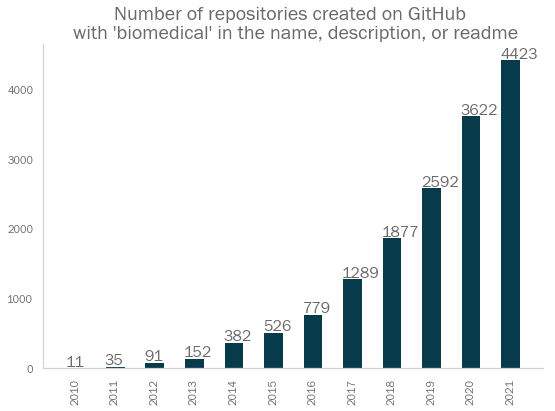

In [21]:
# visualize results
df = pd.read_csv('github_biomedical_repo_count_yearwise.csv')
fig, ax = plt.subplots(figsize=(8,6))
width = 0.5
ind = 0
x = df['year']
y = df["count"]
bars = ax.bar(x, y, width, color=color_palette[ind])
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x(), yval + 20, round(yval,1))
ind+=1
ax.set_xticks(df['year'])
plt.title("Number of repositories created on GitHub \n with 'biomedical' in the name, description, or readme")
plt.xticks(rotation=90, ha = 'center')
fig.tight_layout()
plot_name = 'github-biomedical-repo-count-yearwise'
save_image_png(fig, current_folder, plot_name)

## bio.tools registry

In [23]:
df = pd.DataFrame(columns = ['year', 'count'])
item_count = 1
year_count = 0
page_number = 0
page_count = 0
search_complete = 0
current_year = 0
while search_complete == 0:
    page_number += 1
    page_count += 1
    clear_output(wait=True)
    print(page_number)
    params = {
        'page' : str(page_number),
        'format': 'json',
        'sort': 'additionDate',
        'ord': 'asc',
    }
    response = requests.get('https://bio.tools/api/tool/', params=params)
    response_json = response.json()
    if 'list' in response_json.keys():
        for item in response_json['list']:
            if page_count == 1 and item_count == 1:
                addition_date = item['additionDate']
                current_year = int(addition_date[:4])
                item_count += 1  
            addition_date = item['additionDate']
            item_year = int(addition_date[:4])
            if item_year == current_year:
                year_count += 1
            else:
                df.loc[len(df.index)] = [current_year, year_count]
                year_count = 1
                current_year = item_year
    else:
        search_complete = 1
df.loc[len(df.index)] = [current_year, year_count]
df.to_csv('bio_tools_count_yearwise.csv')
print("Success: Year-wise number of tools added on bio.tools pulled and saved in a dataframe and in a csv file")

2457
Success: Year-wise number of tools added on bio.tools pulled and saved in a dataframe and in a csv file


In [24]:
print(df)

   year count
0  2015  1294
1  2016   846
2  2017  7758
3  2018  2181
4  2019  2441
5  2020  1937
6  2021  7157
7  2022   944


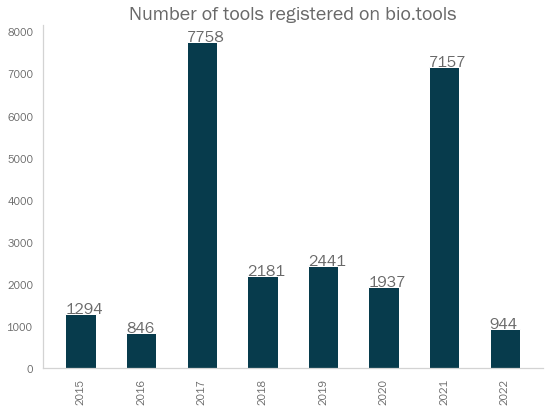

In [26]:
# visualize results
df = pd.read_csv('bio_tools_count_yearwise.csv')
fig, ax = plt.subplots(figsize=(8,6))
width = 0.5
ind = 0
x = df['year']
y = df["count"]
bars = ax.bar(x, y, width, color=color_palette[ind])
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x(), yval + 20, round(yval,1))
ind+=1
ax.set_xticks(df['year'])
plt.title("Number of tools registered on bio.tools")
plt.xticks(rotation=90, ha = 'center')
fig.tight_layout()
plot_name = 'biotools-count-yearwise'
save_image_png(fig, current_folder, plot_name)